In [252]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import yfinance as yf
from finta import TA    
from config import *
import os
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split

importing necessary libraries

In [253]:
def fetch_daily_data(symbol):
    """
    Fetches daily stock data for a given symbol over the last 5 years
    @return: pandas DF containing daily stock data
    """
    today = datetime.now().strftime("%Y-%m-%d")
    five_years_ago = (datetime.strptime(today, "%Y-%m-%d") - timedelta(days=5*365)).strftime("%Y-%m-%d")
    df = yf.download(symbol, start=five_years_ago, end=today)
    # df = yf.download([symbol], '2017-01-01', '2021-12-20')

    return df

    

[*********************100%***********************]  1 of 1 completed


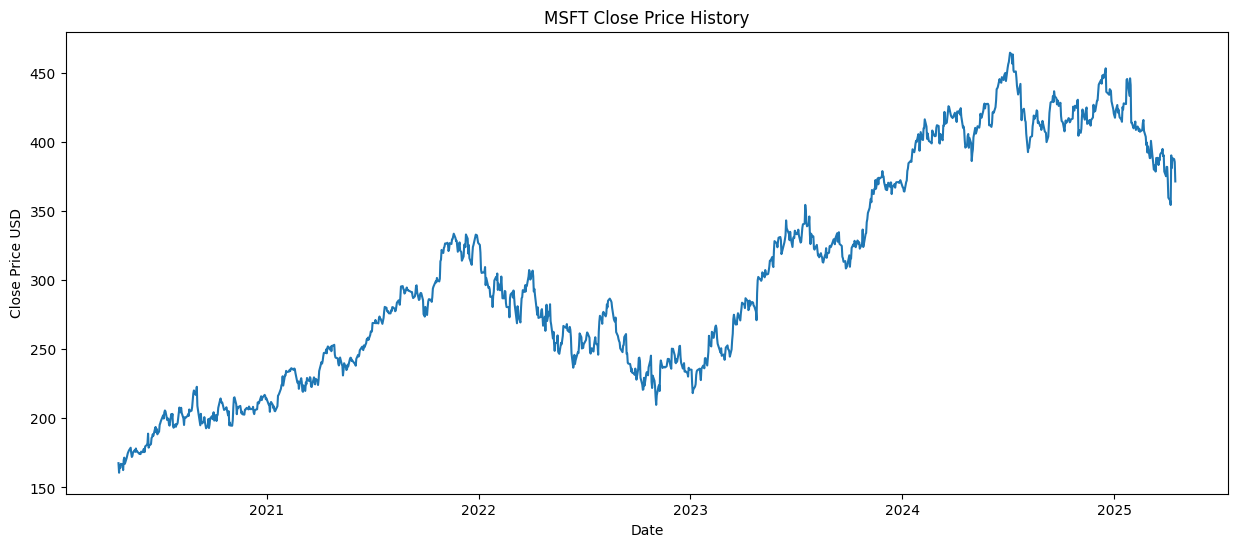

In [254]:
df = fetch_daily_data('MSFT')
df.columns = df.columns.droplevel(1) 
plt.figure(figsize=(15,6))
plt.title('MSFT Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.show();

In [255]:
def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Engineer features from stock data
    @param df: pandas DF containing stock data
    @return: pandas DF containing engineered features
    '''

    df['SMA200'] = TA.SMA(df,200) # simple moving average over 100 days
    df['RSI'] = TA.RSI(df) # Relative Strength Index
    df['ATR'] = TA.ATR(df) # Average True Range
    df['BBWIDTH'] = TA.BBWIDTH(df) # Bollinger Bands Width
    df['Williams'] = TA.WILLIAMS(df) # Williams %R

    df = df.iloc[200:, :] # drop the first 200 rows since we are using 200 day SMA 
    df['Target'] = df.Close.shift(-1) # shift the closing price up one row to predict the next days closing price 
    df.dropna(inplace=True) # drop any rows with missing values
    return df

df = engineer_features(df)
df.head()

/var/folders/cp/q2ltvsgx5dd856zr339ft0z40000gn/T/ipykernel_22362/2904156451.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Target'] = df.Close.shift(-1) # shift the closing price up one row to predict the next days closing price
/var/folders/cp/q2ltvsgx5dd856zr339ft0z40000gn/T/ipykernel_22362/2904156451.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True) # drop any rows with missing values


Price,Close,High,Low,Open,Volume,SMA200,RSI,ATR,BBWIDTH,Williams,Target
Date,,,,,,,,,,,
2021-02-03,234.418137,236.434322,230.810214,231.109279,27158100,199.156193,70.000460,6.043047,0.180741,-6.321826,233.463120
2021-02-04,233.463120,234.649691,231.881039,234.090173,25296100,199.520340,68.344885,5.915571,0.182734,-9.316319,233.646393
2021-02-05,233.646393,234.688253,231.929257,233.675332,18054800,199.858124,68.498859,5.941756,0.187971,-8.903251,233.906876
2021-02-08,233.906876,235.074135,232.305497,234.562854,22211900,200.207260,68.731653,5.839775,0.192037,-9.424375,235.160950
2021-02-09,235.160950,236.115977,232.855356,233.328042,23565000,200.547688,69.885507,5.428406,0.192988,-5.822638,234.244537


#### Simple Moving Average - 100 day 
- Purpose: shows the overall trend over the past 100 days 
- Use in ML:
- Helps model understand if stock is long-term moving upwards or downwards


#### Relative Sitrength Index 
- Purpose: measures momentum - how strongly a stock has moved up or down recently on a 0-100 scale
- Use in ML:
- helps detect potential reversal points or trend exhaustion


#### Average True Range 
- Purpose: measures volatility - how much the price has been fluctuating
- Use in ML:
- Helps capture risk level of a stock 
- Useful for adjusting predictions based on user risk tolerance 


#### Bollinger Band Width 
- Purpose: measures the width Bollinger Bands which expand/contract based on volatility - wider = higher volatility
- Use in ML:
- can indicate a trend change



#### Williams %R
- Purpose: measures overbought/oversold conditions on scale of -100 to 0 
- Closer to 0 is overbought 
- Use in ML
- Good for identifying potential entry or exit points
- Often used with RSI to confirm signals
---
- the target column is created by shifting columns up one
- it essentially makes the next days closing price today's target

In [256]:
def train_test_split(data: pd.DataFrame,perc: float) -> tuple[np.ndarray, np.ndarray]:
    '''
    Splits data into train and test sets
    @param data: pandas DF containing stock data
    @param perc: percentage of data for test set
    @return: train set, test set
    '''

    ret = data.values
    n = int(len(data) *  (1-perc)) 
    return ret[:n], ret[n:]

In [257]:
train, test = train_test_split(df,0.5)
train

array([[ 2.34418137e+02,  2.36434322e+02,  2.30810214e+02, ...,
         1.80741350e-01, -6.32182613e+00,  2.33463120e+02],
       [ 2.33463120e+02,  2.34649691e+02,  2.31881039e+02, ...,
         1.82734409e-01, -9.31631862e+00,  2.33646393e+02],
       [ 2.33646393e+02,  2.34688253e+02,  2.31929257e+02, ...,
         1.87971215e-01, -8.90325141e+00,  2.33906876e+02],
       ...,
       [ 2.52848541e+02,  2.56047661e+02,  2.51972475e+02, ...,
         1.21338701e-01, -6.07295791e+01,  2.50171127e+02],
       [ 2.50171127e+02,  2.53655715e+02,  2.49423031e+02, ...,
         1.21998463e-01, -6.60031311e+01,  2.49728165e+02],
       [ 2.49728165e+02,  2.50555010e+02,  2.46883410e+02, ...,
         1.18760928e-01, -6.17131227e+01,  2.48369797e+02]])

In [258]:
print(len(df))
print(len(train))
print(len(test))
train[0,:-1] # first row without the last column (target)


1055
527
528


array([ 2.34418137e+02,  2.36434322e+02,  2.30810214e+02,  2.31109279e+02,
        2.71581000e+07,  1.99156193e+02,  7.00004603e+01,  6.04304674e+00,
        1.80741350e-01, -6.32182613e+00])

In [259]:
X = train[:,:-1] # all features/input variables except last column (target) - info used to predict target
y = train[:,-1] # contains only the target values (stock price trying to predict)
# overall this code separates the features and target values from the ds to train the model 
y

array([233.46311951, 233.64639282, 233.90687561, 235.16094971,
       234.24453735, 235.85554504, 236.33789062, 235.09341431,
       236.11833191, 235.72192383, 232.99525452, 226.74902344,
       225.5500946 , 226.78773499, 221.41174316, 224.68954468,
       229.09864807, 226.13018799, 220.02905273, 219.22650146,
       223.93536377, 219.86468506, 226.04318237, 224.72821045,
       229.28233337, 227.94799805, 227.03907776, 229.84313965,
       229.19532776, 223.08447266, 222.72668457, 228.18005371,
       229.717453  , 227.66758728, 224.65083313, 228.65382385,
       227.45489502, 224.17709351, 227.96733093, 234.32958984,
       240.82720947, 239.65722656, 241.62971497, 244.86882019,
       247.38279724, 247.4407959 , 249.93544006, 247.13137817,
       250.91201782, 252.1109314 , 250.17713928, 249.7130127 ,
       251.95629883, 248.65910339, 252.50744629, 252.89416504,
       253.30026245, 246.13546753, 244.15333557, 243.83424377,
       243.52482605, 239.58952332, 238.31324768, 241.46

In [260]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV


params = {
    'max_depth': [3,6], # determines the max depth of each tree in the model 
    'learning_rate': [0.05], # controls the step size in each boosting iteration which prevents overfitting
    'n_estimators': [700,1000], # number of trees in the model
    'colsample_bytree': [0.3, 0.7], # determines the fraction of features to randomly sample for each tree, helps prevent overfitting
}

# The learning rate is a key hyperparameter that determines how much each new tree added to the model contributes to the overall prediction
# It acts as a scaling factor for the corrections made by each successive tree in the boosting process

# How it works:
# Sequential Learning: trees are added one at a time each aiming to correct the errors (residuals) of the existing ensemble
# The learning rate multiplies the output of each new tree before adding it to the ensemble 
# A learning rate of 1.0 means each tree's corrections are fully applied 
# Values less than 1 reduce the impact of each tree - making the model learn more slowly and cautiously 
# Lower Learning Rate -- model learns slower, requires more trees, prevents overfitting, training takes longer 


# XGBoost Regressor is a type of gradient boosting model that build trees one at a time, each tree is trained
# to correct the errors of the previous tree by focusing on the examples that were misclassified 
# the model then combines the predictions of all trees to make a final prediction
# gradient boosting is a technique that build an ensemble of weak models to create a strong predictive model
xgbr = XGBRegressor(seed = 20) # initalize the model 


# GridSearchCV is used to find the best parameters for the model by searching through a grid of parameters
# take xgbr model, params, neg_mean_sqaured error as the scoring metric, verbose = 1 for detailed output
# the scoring is neg_mean_squared_error which is the average of the squared differences between the predicted and actual values
# this metric penalizes large errors more heavily which helps the model focus on minimizing large errors
# the verbose works to print the best parameters and the lowest RMSE 
modl = GridSearchCV(estimator=xgbr, param_grid=params, scoring = 'neg_mean_squared_error', verbose=1)
modl.fit(X, y) # fit the model 


print('Best Parameters:', modl.best_params_)
print('Lowest RMSE:', (-modl.best_score_)**(1/2.0))
# the model.best_params_ is the best parameters found by grid search
# best parameters are the ones that result in the lowest RMSE 

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 700}
Lowest RMSE: 6.462050027437732


In [261]:
# this is the model that will be used to make predictions
# the objective is to minimize the error between the predicted and actual values
# reg means regression and squarederror is the loss function 
# gamma is the minimum loss reduction required to make a further partition on a leaf node of the tree
model = XGBRegressor(objective = 'reg:squarederror', n_estimators = 750, colsample_bytree = 0.7, learning_rate = 0.05, max_depth = 3, gamma = 1)
model.fit(X,y) 

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=750, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [262]:
test[0,:] # this accesses the first row of the test set 

array([ 2.48369797e+02,  2.55496441e+02,  2.47641376e+02,  2.51815002e+02,
        2.66534000e+07,  2.47433635e+02,  4.89177723e+01,  5.08272785e+00,
        1.15907442e-01, -5.37558489e+01,  2.44698166e+02])

In [263]:
val = np.array(test[0,:-1]).reshape(1,-1) # this line converts the first row of the test set into a numpy array and reshapes it into a 1x-1 array 
pred = model.predict(val) # this line uses the model to make a prediction on the first row of the test set 
pred

# first it takes the first row of the test data and removes the last column (target)
# then it reshapes the resulting array into a 2D array with 1 row 
# this array represents the features of stock data for a particular day
# next it uses the trained model to make a prediction on this day's features 
# the predict function takes the reshaped array and returns the predicted value 

array([250.37508], dtype=float32)

In [264]:
def xgb_predict(train: pd.DataFrame, val: pd.DataFrame) -> float:
    '''
    # Predicts closing price of stockusing XGBoost Regressor 
    @param train: pandas DF containing training data 
    @param val: pandas DF as a validation set 
    @return: float prediction

    ---
    - First the training data is converted to a numpy array 
    - Then the features and target values are separated 
    - Then the model is initialized and trained on the training data 
    - Then the validation set is converted to a numpy array and reshaped into a 2D array with 1 row
    - Then the model is used to make a prediction on the validation set 
    - The prediction is then returned as a float
    '''
    train = np.array(train)
    X, y = train[:,:-1], train[:,-1]
    model = XGBRegressor(objective = 'reg:squarederror', n_estimators = 1000, learning_rate = 0.05, colsample_bytree = 0.7, max_depth =3, gamma = 1)
    model.fit(X,y)
    val = np.array(val).reshape(1,-1)
    pred = model.predict(val)
    return pred[0]

In [265]:
# using the xgb_predict function 
# passing in the training data and the first row of the test data 
# the goal is to used the trained model to predict the closing price of the stock for the first row of the test data 
xgb_predict(train, test[0, :-1])


250.3748

In [266]:
def mape(actual, pred) -> float:
    ''' 
    Calculates the mean absolute percentage error between the actual and predicted values 
    @param actual: array containing actual values 
    @param pred: array containing predicted values
    @return: float mape
    '''
    actual = np.array(actual)
    pred = np.array(pred)
    mape = np.mean(np.abs((actual - pred) / actual) * 100)
    return mape 


In [267]:
from sklearn.metrics import root_mean_squared_error

def validate(data, perc):
    '''
    Validates the model by predicting the closing price of the stock for each day in the test set 
    @param data: df containing stock data 
    @para perc: percentage of data for test set 
    @return: float error, float MAPE, array of actual targetvalues, array of predicted values
    '''
    predictions = []
    train, test = train_test_split(data, perc)
    # data is split into training and testing sets 
    history = [x for x in train] # history is a list of the elements in the training set 


    # for loop iterates over each element in the testing set 
    # for each iteration, the input features (X_test) and target value (y_test) are extracted from the test set 
    # the xgb_predict function is then called to predict the target value using the history the history data 
    # the predicted value is then added to the predictions list  
    for i in range(len(test)):
        X_test, y_test = test[i,:-1], test[i,-1]
        pred = xgb_predict(history, X_test)
        predictions.append(pred)

        history.append(test[i])

    # the mean squared error is calculated between the actual target values and predicted values 
    error = root_mean_squared_error(test[:,-1], predictions)

    # the mape is calculated between the actual and predicted values 
    MAPE = mape(test[:,-1], predictions)


    return error, MAPE, test[:,-1], predictions

In [268]:
rmse, MAPE, y, pred = validate(df, 0.5)

In [269]:
print("RMSE:", f'{rmse}')
print("MAPE:", f'{MAPE}')
print(y)
print(pred)

RMSE: 6.425238423511657
MAPE: 1.309933623184928
[244.69816589 249.94473267 256.70715332 261.28442383 271.87591553
 275.05535889 267.96810913 269.49383545 268.02713013 273.31304932
 276.17752075 272.05310059 270.92111206 276.11843872 279.60302734
 283.78649902 282.73327637 282.68399048 279.88845825 287.03479004
 284.85946655 278.40209961 279.05178833 285.30239868 281.66033936
 284.27865601 283.85540771 283.93414307 281.63076782 281.2862854
 277.35873413 271.1081543  290.74578857 300.05767822 302.44967651
 300.77627563 300.62866211 299.63439941 300.62866211 305.78662109
 303.81787109 302.19372559 307.42062378 305.2550354  304.13287354
 304.61520386 306.85955811 309.75982666 314.21881104 314.04116821
 316.84286499 311.00280762 309.61184692 321.51889038 328.39474487
 326.73742676 323.95550537 328.08892822 330.87081909 331.40359497
 329.17404175 319.01315308 320.86779785 322.3770752  327.3687439
 329.77581787 332.78466797 343.39938354 337.70724487 333.4850769
 329.05569458 335.12261963 330.

In [270]:
# takes the predicted values from the model and converts them into a numpy array
pred = np.array(pred)

# then it combines these predicted values with the actual target values from the test set 
# the numpy.c_ function allows us to see the predicted values alongside the actual target values
test_pred = np.c_[test, pred]

In [271]:
df_TP = pd.DataFrame(test_pred, columns = ["Close",	"High",	"Low",	"Open",	"Volume",	"SMA200" ,"RSI",	"ATR",	"BBWIDTH",	"Williams",	"Target", "Pred"])

In [274]:
# adds the date column to the dataframe
df = df.reset_index(names='Date')

# Extract only the Date and Target from df
df_dates = df[['Date', 'Target', 'Close']]

# Merge df_TP with df_dates on the Target column
df_TP = pd.merge(df_TP, df_dates, on='Target', how='left')

# sort dataframe by date 
df_TP = df_TP.sort_values(by='Date').reset_index(drop=True)

Text(0, 0.5, 'Price USD')

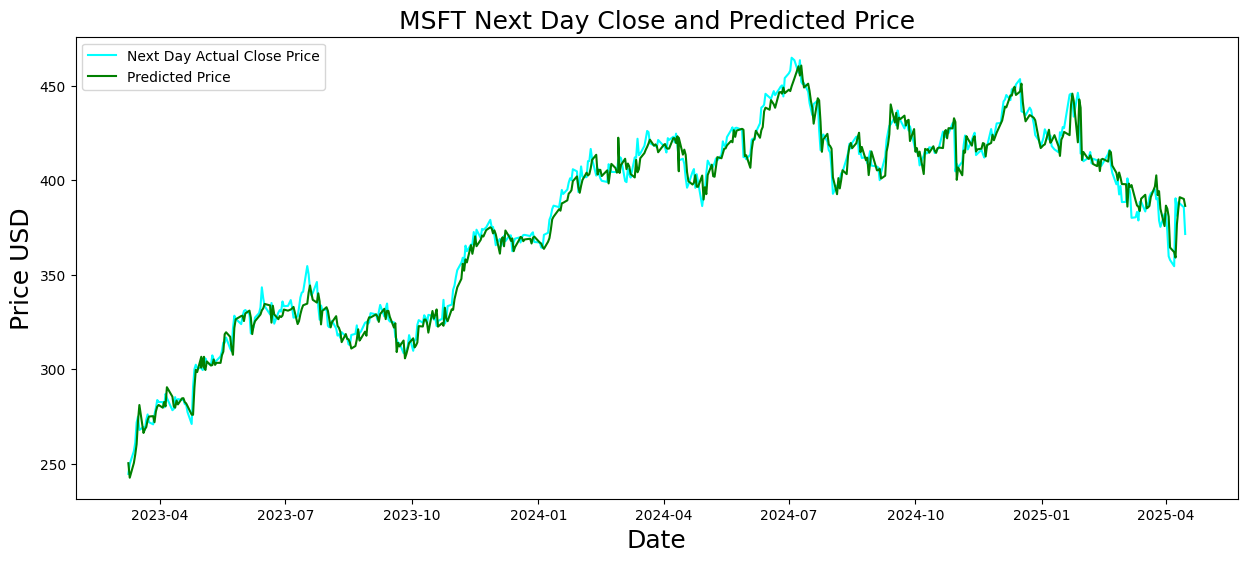

In [275]:
plt.figure(figsize = (15,6))
plt.title("MSFT Next Day Close and Predicted Price", fontsize = 18)
plt.plot(df_TP['Date'],df_TP['Target'], label = 'Next Day Actual Close Price', color = 'cyan')
plt.plot(df_TP['Date'], df_TP['Pred'], label = 'Predicted Price', color = 'green', alpha = 1)
plt.xlabel('Date',fontsize = 18)
plt.legend(loc = 'upper left')
plt.ylabel('Price USD', fontsize = 18)